<a href="https://colab.research.google.com/github/zain2864/QOSF_Cohort_8_Task_2_Quantum-Algorithm-to-Detect-Negative-Numbers/blob/main/QOSF_Cohort_8_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<b>QOSF Cohort 8 Task #2 Summary
#<b>Quantum Algorithm to Detect Negative Numbers </b>
by Zain Mughal
</b>
<br>

### <b>Objective: </b>
To devise an efficient quantum algorithm to determine if a list of numbers contains any negative integers.
In this task, Grover's Algorithm was used.
<br>


### <b>Logic and Procedures Used: </b>

<b>Binary Representation:</b> Every integer was transformed into its two's complement binary representation. This ensured that negative numbers have a leading '1' bit.

<b>Quantum Circuit Setup:</b> A quantum circuit was initialized with a number of qubits based on the maximum bit-length needed from the list. All qubits were initialized in a superposition state.

<b>Oracle Creation:</b> The quantum oracle's role is crucial in Grover's algorithm. Its purpose is to recognize the solution and introduce a phase flip to the desired solution state. In this task, the oracle was designed to mark (flip the phase of) states that correspond to negative numbers. Due to the two's complement representation, this was a simple task of marking states with a leading '1' bit by using a Multi-controlled-Phase gate, to create a MCZ gate, on the auxiliary qubit when it encounters a leading '1' in the binary representation.

<b>Amplitude Amplification:</b> Central to Grover's algorithm is the principle of amplitude amplification. It's the process by which the amplitude of the desired state(s) is increased, whereas the amplitude of undesired states gets diminished.

<b>Grover's Diffusion Operator:</b> After the oracle, Grover's diffusion operator was applied. This operator aids in amplifying the amplitude of the marked states. It achieves this by inverting the amplitude of all states around the average amplitude. It was implemented using a series of Hadamard, X-gates, and a multi-controlled Toffoli gate.

<b>Iterations:</b> The oracle and diffusion steps were repeated approximately
<sup>&#960;</sup>/<sub>4</sub><span>&#8730;</span> N times, where N is the number of items in the list. This is the optimal number of iterations based on Grover's algorithm to maximize the probability of measuring a marked state.
<br>


### <b>Efficiency and Justification:</b>
The use of Grover's algorithm makes this approach significantly faster than any classical algorithm for the same purpose. Classically, one would have to check each number individually, leading to a linear runtime in the worst case. However, with Grover's algorithm, we achieve a quadratic speedup, making it closer to a <span>&#8730;</span> N runtime.

It's essential to note that while Grover's algorithm provides a speedup, it offers a probabilistic solution. This means that while there's a high probability of obtaining the correct answer, it's not guaranteed in every single run, unlike deterministic classical algorithms. However, the probability of success can be made arbitrarily high by repeating the quantum procedure a few times.

Furthermore, by using the two's complement representation for the numbers, we efficiently encode the sign of the number in the most significant bit. This allows the oracle to be extremely simple and efficient, marking negative numbers by just checking the leading bit.
<br>
<br>

###<b>Validity for All Kinds of Numbers:</b>
The proposed quantum approach is valid for all integers, both positive and negative. Here's why:

<b>1. Universal Two's Complement Representation:</b> Every integer, whether positive or negative, can be represented in two's complement binary form. This representation ensures that negative numbers always have a '1' as the leading bit, making them distinguishable from positive numbers and zero. This simple yet powerful characteristic ensures that the quantum solution is valid for all negative numbers. The use of the two's complement representation is universal in digital systems for signed number representation, further validating the approach for any list of integers.
<br>

<b>2. Scalability:</b> The quantum circuit's size scales with the maximum bit-length of the numbers in the list. Hence, even as numbers grow in magnitude, they can still be processed by just increasing the number of qubits in the circuit.
<br>

<b>3. Robust Oracle:</b> The oracle's design ensures that it will always mark states corresponding to negative numbers, regardless of the magnitude or specific value of the number.

<br>


###<b>References Used: </b>


<b>1. Quantum Complexity Theory (QCT), Bernstein, Ethan, and Umesh Vazirani.: </b> This paper provided an in-depth analysis of the efficiency and complexity of quantum algorithms. Leveraging its insights, this task implemented the Grover's algorithm ensuring that the quantum circuit design adhered to the principles ensuring optimal efficiency. The paper's discussion on quantum oracle was particularly useful in designing the oracle for the problem.
<br>

<b>2. Rapid Solutions in Quantum Computing (RSQC), Deutsch, David, and Richard Jozsa.: </b> RSQC discussed the speed advantages quantum algorithms could offer over classical counterparts. Inspired by its discussions, this task aimed to demonstrate how Grover's algorithm can provide rapid solutions, especially when searching unsorted databases, which is akin to the problem of searching for a negative number in an unsorted list.
<br>

<b>3. Database Search in Quantum Computing (DSQC), Grover, Lov K. : </b> DSQC provided a comprehensive understanding of how Grover's algorithm can be applied to search problems. The paper's detailed analysis of Grover's iterative structure and the diffusion operator was pivotal in creating the quantum circuits for the problem. The paper's illustrations and circuit designs greatly influenced the circuit implementation.
<br>

<b>4. Qiskit Documentation:</b> The official documentation provided guidance on the implementation details of the quantum circuits and algorithms using the Qiskit library.


In [ ]:
#Libraries
!pip install qiskit
!pip install qiskit-aer
!pip install pylatexenc

import qiskit
from qiskit import Aer, QuantumCircuit, execute
from qiskit.visualization import plot_histogram
from math import pi, sqrt

In [2]:
def twos_complement(num, num_qubits):
    """Helper Function to compute the two's complement binary representation."""
    if num >= 0:
        return format(num, f'0{num_qubits}b')
    else:
        pos_repr = format(abs(num), f'0{num_qubits}b')
        inverted = ''.join(['1' if bit == '0' else '0' for bit in pos_repr])
        inverted_int = int(inverted, 2)
        neg_repr = format(inverted_int + 1, f'0{num_qubits}b')
        return neg_repr

#Test:
num_qubits = 8
print(twos_complement(3, num_qubits))  # Expected: 00000011
print(twos_complement(-3, num_qubits))  # Expected: 11111101
print(twos_complement(14, num_qubits))  # Expected: 00001110
print(twos_complement(-5, num_qubits))  # Expected: 11111011

00000011
11111101
00001110
11111011


In [3]:
def find_negative_numbers(list_numbers, verbose=False, visualize=False):
    """
    Purpose:
    This function determines if a given list of numbers contains any negative integers by leveraging Grover's quantum search algorithm.

    Parameters:
    - list_numbers: List of integers that you want to check for the presence of negative numbers.
    - verbose (default: False): If set to True, the function will print the quantum measurement counts.
    - visualize (default: False): If set to True, the function will display a visual representation of the quantum circuit.

    Internal Functions:
    1. oracle():
    Purpose: Marks the quantum states corresponding to negative numbers.
    Logic: Uses a Multi-controlled-Phase gate to create a MCZ gate and applies on the auxiliary qubit if the leading bit (sign bit in two's complement representation) is '1', which indicates a negative number.

    2. grover_diffusion():
    Purpose: Amplifies the probabilities of the marked states while suppressing the others.
    Logic: It applies a series of quantum gates (Hadamard, X-gates, and a multi-controlled Toffoli gate) to implement the diffusion operation characteristic of Grover's algorithm.

    Return Value:
    - True if a negative number is detected in the list.
    - False otherwise.
    """

    def oracle():
        qc.mcp(pi, list(range(num_qubits-1)), num_qubits-1)

    def grover_diffusion():
        qc.h(range(num_qubits))
        qc.x(range(num_qubits))
        qc.h(num_qubits - 1)
        qc.mct(list(range(num_qubits - 1)), num_qubits - 1)
        qc.h(num_qubits - 1)
        qc.x(range(num_qubits))
        qc.h(range(num_qubits))

    #Prepare two's complement binary representation
    num_qubits = max([num.bit_length() for num in list_numbers]) + 1  # +1 for sign bit
    binary_representations = [twos_complement(num, num_qubits) for num in list_numbers]

    #Initialize Circuit
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h(range(num_qubits))

    #Optimal Grover Iteration Calculation
    N = len(list_numbers)
    iterations = int((pi/4) * sqrt(N))

    #Grover's algorithm
    for _ in range(iterations):
        oracle()
        grover_diffusion()

    qc.measure(range(num_qubits), range(num_qubits))

    # Executing circuit
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, shots=1000).result()
    counts = result.get_counts()

    if verbose:
        print(counts)
        display(plot_histogram(counts))

    if visualize:
        fig = qc.draw(output='mpl')
        display(fig)

    #Results
    for key, value in counts.items():
        state_int = int(key, 2)
        if state_int < len(list_numbers) and list_numbers[state_int] < 0:
            return True
    return False

#Results and Circuits

{'1100': 25, '0010': 30, '0000': 28, '1110': 44, '1111': 500, '0001': 31, '1101': 38, '0100': 39, '0101': 39, '1001': 27, '0110': 22, '1000': 30, '1010': 35, '1011': 42, '0011': 29, '0111': 41}


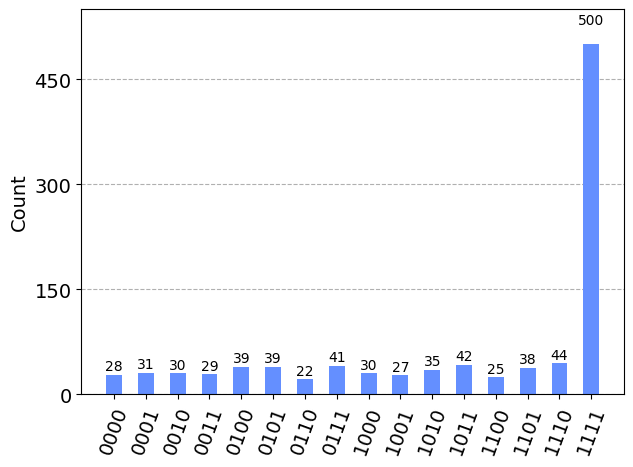

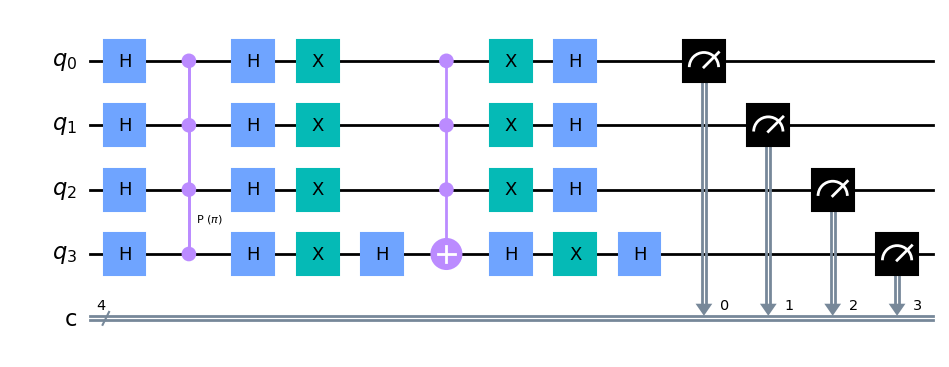

True


In [4]:
print(find_negative_numbers([1,2,-3,4,5,6], verbose=True, visualize=True))  # Expected output: True

{'11000': 13, '00100': 26, '11100': 25, '10010': 23, '10101': 28, '11010': 24, '00101': 19, '01001': 27, '10001': 19, '11110': 15, '10000': 28, '11001': 16, '00000': 19, '11011': 27, '11111': 285, '01110': 25, '10011': 24, '01011': 21, '11101': 30, '01101': 27, '01111': 31, '00111': 26, '00011': 22, '10111': 25, '10100': 16, '00001': 26, '00110': 22, '01010': 17, '01000': 24, '01100': 21, '10110': 20, '00010': 29}


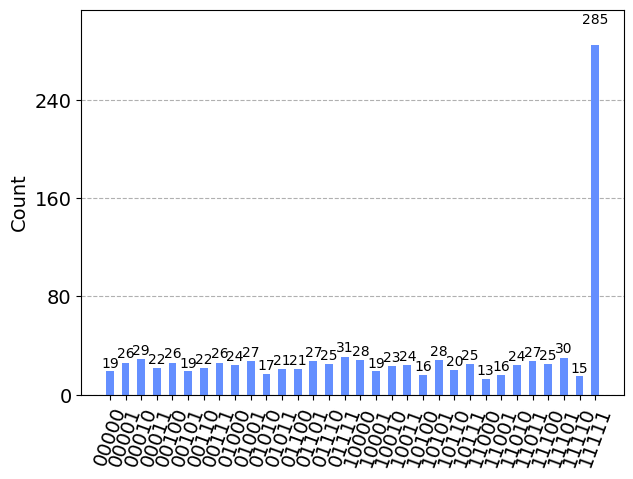

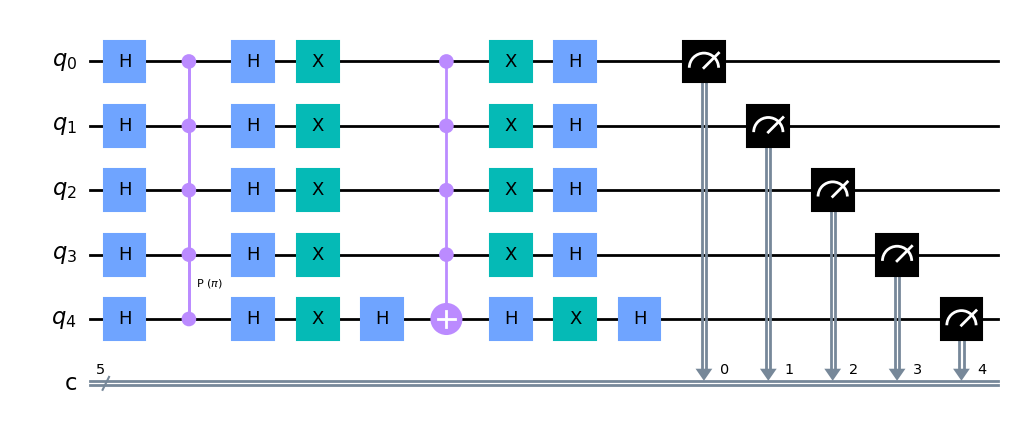

False


"\nIn a list which contains only positive numbers, the most probable outcome is the state '11111'. \nThis might seem like it's pointing to a negative number due to the leading '1', but this state doesn't correspond to any number in the list (the state '11111' corresponds to a position beyond that). \nHence, the function returns False, which is the expected result.\n"

In [9]:
print(find_negative_numbers([1,3,8,10], verbose=True, visualize=True))   # Expected output: False

"""
In a list which contains only positive numbers, the most probable outcome is the state '11111'.
This might seem like it's pointing to a negative number due to the leading '1', but this state doesn't correspond to any number in the list (the state '11111' corresponds to a position beyond that).
Hence, the function returns False, which is the expected result.
"""

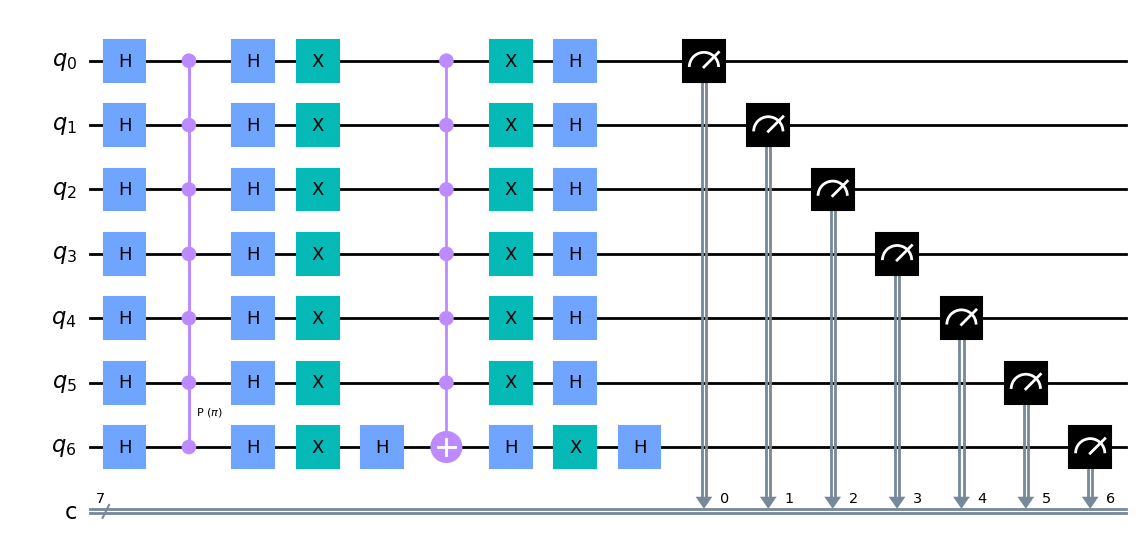

False


In [6]:
print(find_negative_numbers([14,3,16,5,60], verbose=False, visualize=True))   # Expected output: False


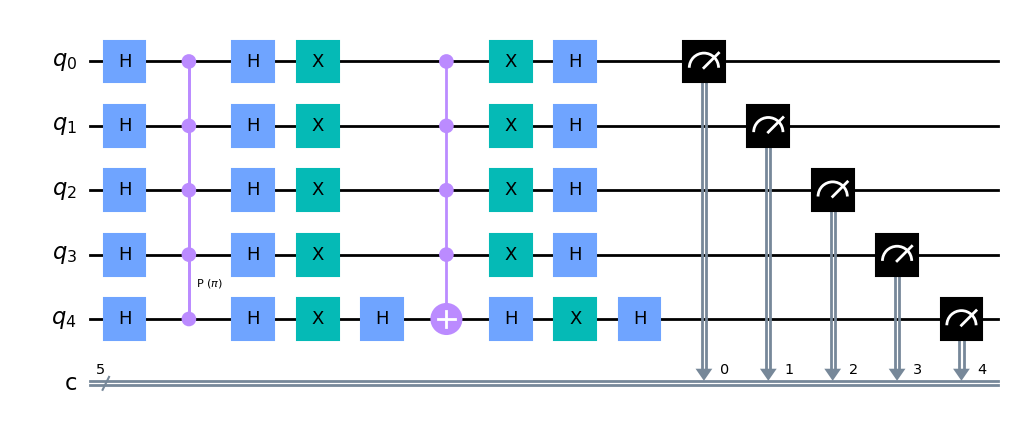

True


In [7]:
print(find_negative_numbers([-3,5,-11,3], verbose=False, visualize=True))   # Expected output: True

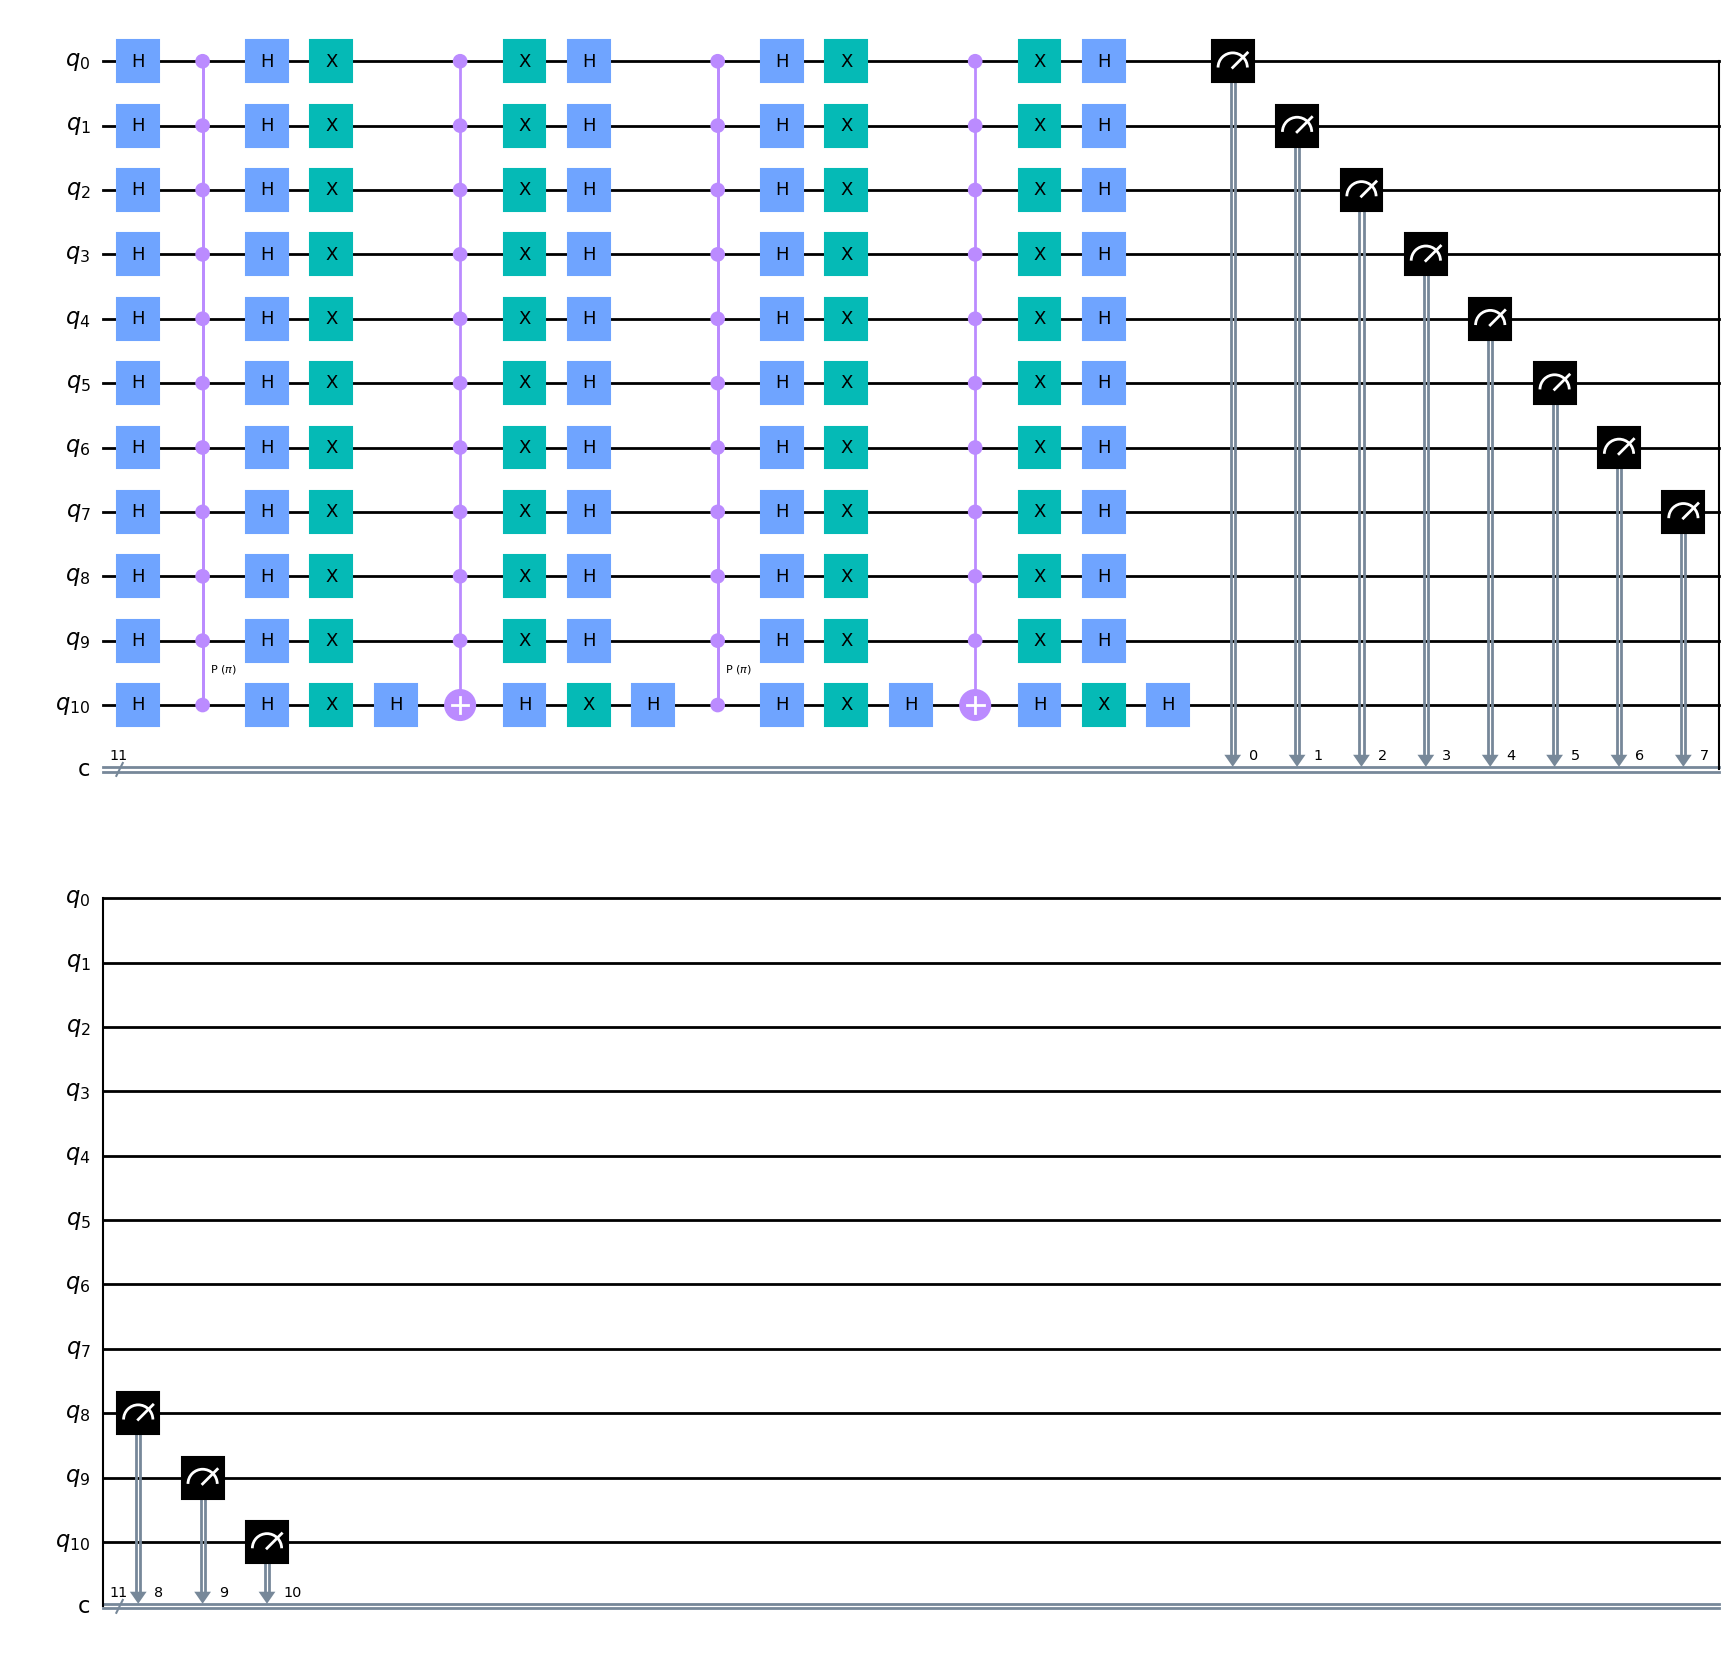

True


In [10]:
print(find_negative_numbers([50,30,40,100,800,12,1021,-8,16,32,64], verbose=False, visualize=True))   # Expected output: True